# 21M.387 Fundamentals of Music Processing
## Beat Detection 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

import sys
sys.path.append("../common")
from util import *
import fmp

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## Reading

Chapter 6.3 (pp 328 – 341)

<img src="images/book_cover.png" width=200>

## Beat Tracking by Dynamic Programming

- Assumes mostly steady beat.
- Assumes beats generally coincide with large values of the Novelty Signal.
- Requires an estimate of what the general tempo is.

The goal is to create a _beat sequence_. Let's call that $B$:  
$B = (b_1, b_2, b_3, ... b_L)$

Each $b_l$ is a _beat location_ - a timestamp in the Novelty Curve $\Delta(n)$.  
There are $L$ beats in the beat sequence.

We want to balance two factors:

1. Beat locations should line up with large values of $\Delta(n)$.
- The delta between any two consecutive beats should be close to $\hat \delta$, the _beat interval_.

$\hat \delta$ is the tempo estimate in units of samples. To compute it:  
Assuming $\hat \tau$ is the tempo estimate in BPM and $F_f$ is the sampling rate of $\Delta(n)$:  
$$\hat \delta = F_f \cdot {60 \over \hat \tau}$$

Next, we construct $\mathbf{S}$, a _Score Function_ that lets us evaluate a beat sequence $B$.

$\mathbf{S}(B) = [\text{beats align with onsets}] + \lambda [\text{beat deltas} \simeq \hat \delta]$

For the first part:
$\sum_{l=1}^L \Delta(b_l)$

For the second part:
$\sum_{l=2}^L P_{\hat \delta}(b_l - b_{l-1})$

What is $P_{\hat \delta}(\delta)$?

It should be a function that is large when $\delta = \hat \delta$, and should gradually fall off when $\delta$ gets bigger or smaller than $\hat \delta$:

<img src="images/delta_penalty.png" width=600>

$$P_{\hat \delta}(\delta) = -(\log_2(\delta / \hat \delta))^2$$

It is a _logarithmic function_. Half-tempo produces the same penalty has double-tempo.

So, the beat-score function for a particular series of beats $B$ is:  
$$\mathbf{S}(B) = \sum_{l=1}^L \Delta(b_l) + \lambda \sum_{l=2}^L P_{\hat \delta}(b_l - b_{l-1})$$


Example:

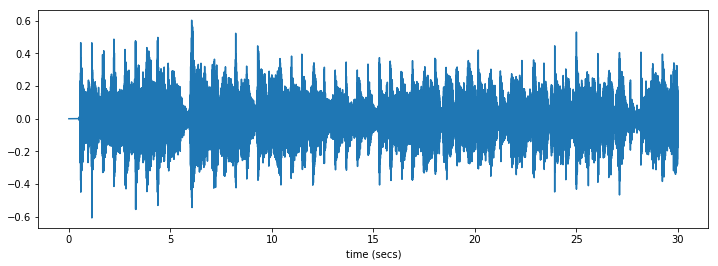

In [4]:
snd = load_wav("audio/beatles_being_for_the_benefit_of_mr_kite.wav", 0, 30)
fs = 22050
plot_and_listen("audio/beatles_being_for_the_benefit_of_mr_kite.wav", 30)

Create the Novelty Function using the Spectral Method with parameters:
- $N=1024$
- $H=512$
- $\gamma=10$

feature rate = 43.07Hz


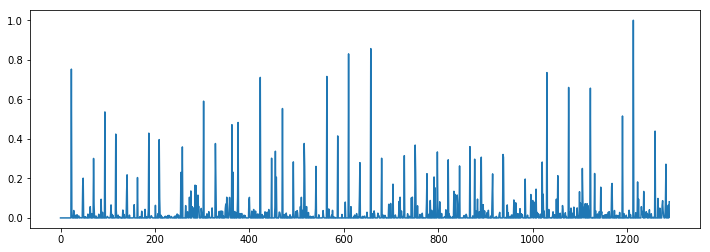

In [5]:
win_len = 1024
hop_size = 512
nov = fmp.spectral_novelty(snd, win_len, hop_size, 10)
ff = fs / float(hop_size)
print "feature rate = %.2fHz" % ff
plt.plot(nov);

The tempo of this song is approximately 111 BPM. We assume this for now, and we will show how to compute it later on.

So: $\hat \tau = 111$

In [6]:
bpm = 111.
est_period = ff * 60 / bpm
print "period = %.2f samples" % est_period
est_period = int(round(est_period))
print "rounded to = %d samples" % est_period

period = 23.28 samples
rounded to = 23 samples


This is the beat score function:

In [7]:
def beat_score(nov, beats, est_period, lam=10):
    a = np.sum(nov[beats])
    deltas = beats[1:] - beats[:-1]
    b = np.sum (- (np.log2( deltas / float(est_period)) ** 2))
    return a + lam * b

This is an example of the beat_score function at work.  
Each example beat sequence below has its own beat score.


In [8]:
@interact(period=(20, 28), offset=(0, 30), rnd=False)
def test_beat_score(period, offset, rnd) :
    num = int(len(nov) / period) - 1
    beats = np.arange(num) * period + offset
    if rnd:
        beats = beats + np.random.random(num) * 3
    beats = beats.astype(np.int)

    plt.plot(nov);
    plt.vlines(beats, 0, 1, 'r')
    txt = 'score = %.3f' % beat_score(nov, beats, est_period)
    plt.text(0, 1.1, txt, fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=24, description=u'period', max=28, min=20), IntSlider(value=15, description=u'offset', max=30), Checkbox(value=False, description=u'rnd'), Output()), _dom_classes=('widget-interact',))

Now, we have an optimization problem:

Given the score function $\mathbf{S}(B)$, and all possible beat sequences, find the beat sequence $B^*$ that maximizes  $\mathbf{S}(B)$.

$$B^* = \text{argmax}\lbrace \mathbf{S}(B) \mid B \in \mathcal{B}^N\rbrace$$

## Dynamic Programming

The number of different beat sequences is ridiculously large. It is exponential in $N$, the number of "beat slots"

In [9]:
dur = 2
num_slots = int(dur * ff)
print "N=%d slots for novelty function of %d seconds" % (num_slots, dur)
print "number of beat sequences: %d" % 2 ** num_slots

N=86 slots for novelty function of 2 seconds
number of beat sequences: 77371252455336267181195264


Like we did in Dynamic Time Warping, we can use Dynamic Programming to find the optimal sequence without trying them all.

Similar technique to DTW: 
- work on local sub-problems
- accumulate local score into a global vector

### Accumulated Score Vector $\mathbf{D}$

Define a vector $\mathbf{D}$ of length $N$ where each element:
$$\mathbf{D}(n) = \max \lbrace \mathbf{S}(B) \mid B \in \mathcal{B}^N_n \rbrace$$

where $\mathcal{B}^N_n$ is the set of all beat sequences ending at position $n$.

In other words, $\mathbf{D}(n)$ stores the _score_ of the best (highest scoring) beat sequence ending at $n$.

Caution: $\mathbf{D}(n) \mid n \in [0:N]$ whereas $\Delta (n) \mid n \in [1:N]$.


$\mathbf{D}(n)$ is calculated as follows:


First, initialize $\mathbf{D}(0)$:
$$\mathbf{D}(0) = 0$$

Next, compute each value of $\mathbf{D}(n)$, for $n \in [1:N]$:

$$
\mathbf{D}(n) = \Delta(n) + \max
\begin{cases}
0,  \\
\max_{m \in [1:n-1]} \lbrace \mathbf{D}(m) + \lambda P_{\hat \delta}(n - m)\rbrace \\
\end{cases}
$$

The important step above is the inner $\max$ statement. It allows the current time-step $n$ to be "arrived at" from the best possible previous location (which has the highest accumulated score combined with the smallest penalty).

Think of it like this: what's the best way to get _here_ $[n]$ coming from _over there_ $[1:n-1$]?

Finally, in order to actually find the optimal beat sequecne $B^*$, we must remember which $m$ produced the $\max$ calculation above and store that in a backtracking vector $\mathbf{P}$. 

### Example

Here is a toy example. 

For simplicity, we use $\lambda = 1$ and $P_{\hat \delta}(\delta) = - (\delta - \hat \delta)^2$

Here $\hat \delta = 3$
<img src="images/dyn_prog_toy.png" width=600>

## Estimating Global Tempo

One strategy for estimating the global tempo $\hat \tau$ is to use create a tempogram and average all the rows:

Here is the tempogram:

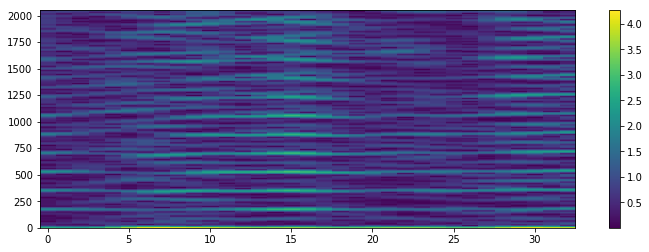

In [10]:
win_len_tg = 256
zp_tg = 16
hop_tg = 32
fft_len = win_len_tg * zp_tg
tg = np.abs(fmp.stft(nov, win_len_tg, hop_tg, zp_tg, centered=False))

plt.imshow(tg, origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar();

Average across all rows

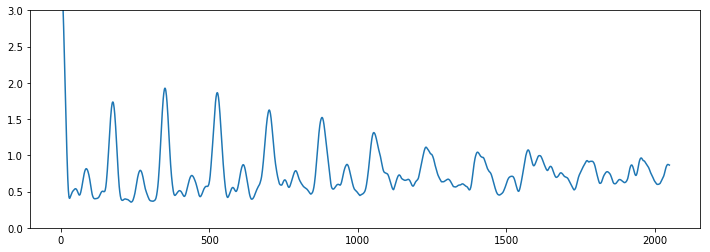

In [11]:
ave_tg = np.mean(tg, axis = 1)
plt.plot(ave_tg);
plt.ylim(0,3);

Pick the maximum, but only from a pre-specified tempo range. For example:
- Min Tempo: 40BPM
- Max Tempo: 200BPM


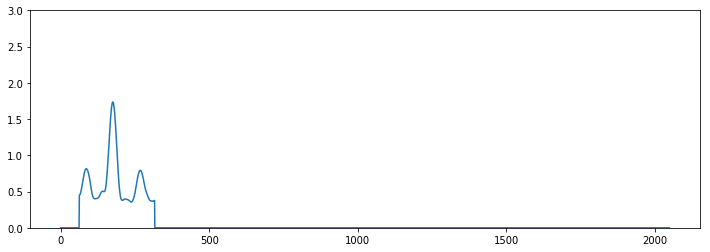

In [12]:
win = fmp.make_tempo_range_window(fft_len, ff, 40, 200)
ave_tg = ave_tg * win
plt.plot(ave_tg)
plt.ylim(0,3);

Finally, locate maximum:

In [13]:
bin = np.argmax(ave_tg * win)
freq_res = ff / fft_len
print 'max bin number', bin
print 'BPM estimate', 60 * bin * freq_res

max bin number 176
BPM estimate 111.030578613


From the BPM, compute the estimated period given the feature rate of $\Delta(n)$

In [14]:
bpm = fmp.estimate_bpm(nov, ff, 40, 200)
est_period = int(round(60 * ff / bpm))
print est_period

23


## Beat Tracking Examples

Now that we have the estimated period, run the Dynamic Programming Beat Tracker
(with $\lambda = 10$)

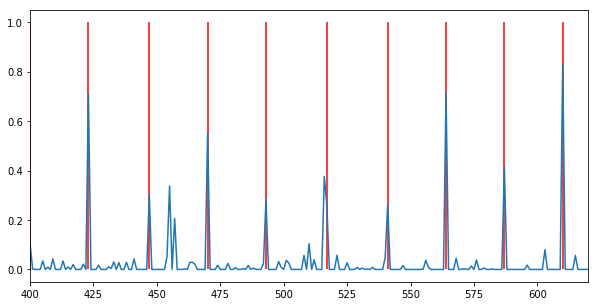

In [15]:
beats = fmp.create_dp_beats(nov, est_period, 10)
plt.figure(figsize=(10, 5))
plt.plot(nov)
plt.vlines(beats, 0, 1, 'r')
plt.xlim(400, 620);

In [16]:
beat_locs = (beats / ff * fs).astype(np.int)
click_snd = load_wav("audio/click.wav")
clicks = fmp.make_clicks(beat_locs, len(snd), click_snd)
ipd.Audio([snd * 0.2, clicks], rate = fs - 1)

### The Effect of changing $\lambda$

In [ ]:
@interact(lmda_idx=(0, 3), mult_idx=(0,2))
def test_beat_track(lmda_idx, mult_idx):
    lmda = (0.1, 1, 10, 100)[lmda_idx]
    mult_factor = (0.5, 1, 2)[mult_idx]
    ep = int(mult_factor * est_period)
    beats = fmp.create_dp_beats(nov, ep, lmda)
    plt.figure(figsize=(10, 5))
    plt.plot(nov)
    plt.vlines(beats, 0, 1, 'r');
    plt.xlim(0, 400)
    text = "$\lambda = %.1f$   $\delta = %d$" % (lmda, ep)
    plt.text(0, 1.1, text, fontsize=20)
    plt.show()
    beat_locs = (beats / ff * fs).astype(np.int)
    clicks = fmp.make_clicks(beat_locs, len(snd), click_snd)
    return ipd.Audio([snd * 0.2, clicks], rate = fs)    

### Another Example

_Chameleon_ by Herbie Hancock

In [ ]:
snd = load_wav("audio/hancock_chameleon.wav", 0, 60)
nov = fmp.spectral_novelty(snd, win_len, hop_size, 10)
bpm = fmp.estimate_bpm(nov, ff, 40, 150)
est_period = int(round(60 * ff / bpm))
print est_period

In [ ]:
@interact(lmda_idx=(0, 3))
def test_beat_track(lmda_idx):
    lmda = (0.1, 1, 5, 10)[lmda_idx]
    ep = int(est_period)
    beats = fmp.create_dp_beats(nov, ep, lmda)
    plt.figure(figsize=(10, 5))
    plt.plot(nov)
    plt.vlines(beats, 0, 1, 'r');
    plt.xlim(0, 400)
    text = "$\lambda = %.1f$   $\delta = %d$" % (lmda, ep)
    plt.text(0, 1.1, text, fontsize=20)
    plt.show()
    beat_locs = (beats / ff * fs).astype(np.int)
    clicks = fmp.make_clicks(beat_locs, len(snd), click_snd)
    return ipd.Audio([snd * 0.2, clicks], rate = fs)    

## Beat Synchronized Features

Another applicaiton of Beat Tracking is to help improve other feature calculations

In [ ]:
snd = load_wav("audio/bach_prelude13.wav", 0, 20)
fs = 22050.
ipd.Audio(snd, rate = fs)

Chromagram of the first 10 seconds:

In [ ]:
chroma1 = fmp.make_chromagram(snd[:int(fs*10)], fs, 4096, 1024, 1)
plt.imshow(chroma1, origin='lower', interpolation='nearest', aspect='auto', cmap='Greys');

Find beats by dynamic programming

In [ ]:
win_len = 512
hop_size = 256
nov = fmp.spectral_novelty(snd, win_len, hop_size, 10)
ff = fs / hop_size
est_bpm = fmp.estimate_bpm(nov, ff, 200, 400)
est_period = int(round(ff * 60 / est_bpm))
beats = fmp.create_dp_beats(nov, est_period, lmda = 5.)
plt.plot(nov)
plt.vlines(beats, 0, 1, 'r');
beat_locs = (beats / ff * fs).astype(np.int)
clicks = fmp.make_clicks(beat_locs, len(snd), click_snd)
ipd.Audio([snd, clicks * 0.5], rate = fs)    

Create a customized chromagram based on a _non-uniform_ spacing of the STFT.

In [ ]:
plt.plot(snd[0:int(fs*3)])
plt.vlines(beat_locs[:13], -0.05, .05, 'r')
plt.show()

Find the maximum beat length to figure out $N$ for the STFT.

- $N = $ next power of 2 above max window length
- $H$ is not a constant - hops vary according to the detected beats
- Use zero-padding up to $N$ as needed
- This method has no overlapping windows

In [ ]:
def sync_stft(x, sync, fft_len):
    num_hops = len(sync) - 1
    num_bins = fft_len / 2 + 1

    output = np.empty((num_bins, num_hops), dtype = np.complex)

    for h in range(num_hops):
        start = sync[h]
        end = sync[h+1]
        wlen = end - start
        sig = x[start:end] * np.hanning(wlen)
        sig.resize(fft_len) # this will zero-pad to the correct length
        
        # take real FFT
        output[: , h] = np.fft.rfft(sig)
    return output

In [ ]:
longest_beat = np.max(beat_locs[1:] - beat_locs[:-1])
fft_len = int(2 ** np.ceil(np.log2(longest_beat)))

print 'longest beat:',  longest_beat
print 'fft_len:', fft_len

spec = np.abs(sync_stft(snd, beat_locs, fft_len)) ** 2
plot_spectrogram(spec[0:600,])
# plot_spectrogram(spec[40:200,:20])

Use this Spectrogram to make a chormagram

In [ ]:
def make_sync_chormagram(snd, fs, sync, gamma = 1, normalize = True):
    # find max window size:
    fft_len = np.max(sync[1:] - sync[:-1])

    # round up to next power of 2:
    fft_len = int(2 ** np.ceil(np.log2(fft_len)))
    
    c_fp = fmp.spec_to_pitch_fb(fs, fft_len, type='hann')
    c_pc = np.tile(np.identity(12), 11)[:, 0:128]
    spec = np.abs(sync_stft(snd, sync, fft_len))
    
    chroma = np.dot(np.dot(c_pc, c_fp), spec ** 2)
    if gamma > 0:
        chroma = np.log(1 + gamma * chroma)
        
    if normalize:
        length = np.linalg.norm(chroma, axis=0, ord = 2)
        chroma = chroma / length
    return chroma

In [ ]:
chroma2 = make_sync_chormagram(snd, fs, beat_locs[:45], 1)
plot_two_chromas(chroma1, chroma2)